In [1]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Read IPSL files

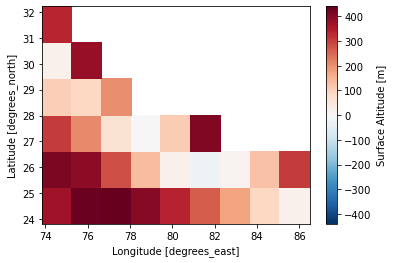

In [2]:
#Read Orography
I_OroData = xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/orog_fx_MIROC6_historical_r1i1p1f1_gn.nc')
Ioro=I_OroData.orog.sel(lat=slice(24,32),lon=slice(74,86))
#Ioro.plot()
#Create Mask
Ioro.values[Ioro.values>500.1]=np.NaN
Imask=Ioro.values/Ioro.values
Ioro.plot()

# GFDL T2m and T2m hilbert

In [3]:
#Read Data
I_t2mData= xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/tas_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
#time1=I_t2mData.indexes['time'].to_datetimeindex()
#I_t2mData=I_t2mData.assign_coords(time=("time", time1))
It2mD = I_t2mData.sel(lat=slice(24,32),lon=slice(74,86))

In [4]:

#Mask data
It2mD.tas.values=It2mD.tas.values*Imask
# area avg
It2mTS=It2mD.mean(dim=['lat','lon'], skipna=True).tas
#Hilbert transform
It2m_hb = np.imag(hilbert(It2mTS.values,axis=0))
It2m_hb_ds = xr.Dataset({'It2m_hb': (('time'), It2m_hb)}, coords={'time': It2mTS.time})
#ISelect only Dec Jan months
It2m=It2mTS[((It2mTS.time.dt.month>11) | (It2mTS.time.dt.month<2))]
It2mhb=It2m_hb_ds.It2m_hb[((It2m_hb_ds.time.dt.month>11) | (It2m_hb_ds.time.dt.month<2))] 


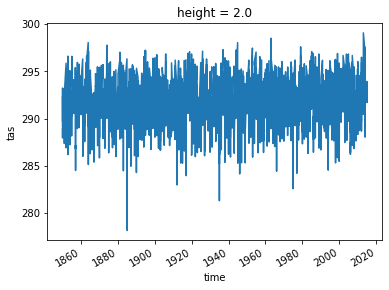

In [5]:
It2m.plot()

# IPSL wind speed and wind speed hilbert

In [6]:
# Read data
Iu10Data = xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/uas_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
Iv10Data = xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/vas_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
#Iu10Data=Iu10Data.assign_coords(time=("time", time1))
#Iv10Data=Iv10Data.assign_coords(time=("time", time1))

Iu10D = Iu10Data.sel(lat=slice(24,32),lon=slice(74,86))
Iv10D = Iv10Data.sel(lat=slice(24,32),lon=slice(74,86))
# Calculate wind speed
Iws = ((Iv10D.vas.values**2)+(Iu10D.uas.values**2))**0.5
Iws_ds = xr.Dataset({'Iws': (('time','lat','lon'), Iws)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Mask
Iws_ds.Iws.values=Iws_ds.Iws.values*Imask
# area avg
IwsTS=Iws_ds.mean(dim=['lat','lon'], skipna=True).Iws
# hilbert
Iws_hb = np.imag(hilbert(IwsTS.values,axis=0))
Iws_hb_ds = xr.Dataset({'Iws_hb': (('time'), Iws_hb)}, coords={'time': IwsTS.time})
#Select Dec and Jan
Iws=IwsTS[((IwsTS.time.dt.month>11) | (IwsTS.time.dt.month<2))] 
Iwshb=Iws_hb_ds.Iws_hb[((Iws_hb_ds.time.dt.month>11) | (Iws_hb_ds.time.dt.month<2))]

# IPSL rh and rh hilbert

In [8]:
#Read Data
I_rhData= xr.open_mfdataset('../../../Data/CMIP6/MIROC6/NDJF/hurs_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_rhData=I_rhData.assign_coords(time=("time", time1))

IrhD = I_rhData.sel(lat=slice(24,32),lon=slice(74,86))
IrhD.hurs.values=IrhD.hurs.values/100.0
#Mask data
IrhD.hurs.values=IrhD.hurs.values*Imask
# area avg
IrhTS=IrhD.mean(dim=['lat','lon'], skipna=True).hurs
#Hilbert transform
Irh_hb = np.imag(hilbert(IrhTS.values,axis=0))
Irh_hb_ds = xr.Dataset({'Irh_hb': (('time'), Irh_hb)}, coords={'time': IrhTS.time})
#ISelect only Dec Jan months
Irh=IrhTS[((IrhTS.time.dt.month>11) | (IrhTS.time.dt.month<2))]
Irhhb=Irh_hb_ds.Irh_hb[((Irh_hb_ds.time.dt.month>11) | (Irh_hb_ds.time.dt.month<2))] 


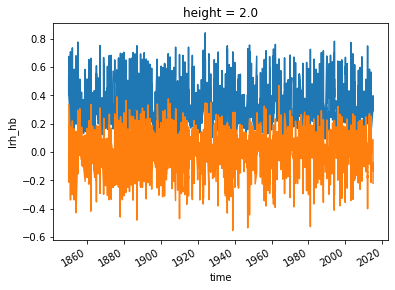

In [9]:
Irh.plot()
Irhhb.plot()

#  IPSL inv and inv hilbert

In [10]:
# Read 850 hPa t
I_tLevData= xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/ta_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_tLevData=I_tLevData.assign_coords(time=("time", time1))

It850D=I_tLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
It850D.ta.values=It850D.ta.values*Imask
# Calculate inv
Iinv = It2mD.tas.values-It850D.ta.values
Iinv_ds = xr.Dataset({'Iinv': (('time','lat','lon'), Iinv)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iinv_ds.Iinv
#Mask
Iinv_ds.Iinv.values=Iinv_ds.Iinv.values*Imask
# area avg
IinvTS=Iinv_ds.mean(dim=['lat','lon'], skipna=True).Iinv
# hilbert
Iinv_hb = np.imag(hilbert(IinvTS.values,axis=0))
Iinv_hb_ds = xr.Dataset({'Iinv_hb': (('time'), Iinv_hb)}, coords={'time': IinvTS.time})
#Select Dec and Jan
Iinv=IinvTS[((IinvTS.time.dt.month>11) | (IinvTS.time.dt.month<2))] 
Iinvhb=Iinv_hb_ds.Iinv_hb[((Iinv_hb_ds.time.dt.month>11) | (Iinv_hb_ds.time.dt.month<2))]



In [11]:
I_tLevData

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 128, lon: 256, plev: 8, time: 19840)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    ta         (time, plev, lat, lon) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.9.5 (http://mpim...
    history:                Mon Feb 01 13:46:46 2021: cdo selmon,1,2,11,12 ta...
    source:                 MIROC6 (2017): \naerosol: SPRINTARS6.0\natmos: CC...
    institution:            JAMSTEC (Japan Agency for Marine-Earth Science an...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-05T01:02:43Z
    data_specs_version:     01.00.31
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              day
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MIROC.MIROC6...
    grid:                   native atmosphere T85 Gaussian grid
    grid_label:             gn
    initialization_index:   1
    institution_id:         MIROC
    mip_era:                CMIP6
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       MIROC6
    parent_time_units:      days since 3200-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source_id:              MIROC6
    source_type:            AOGCM AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               day
    table_info:             Creation Date:(22 July 2019) MD5:b4cefb4b6dbb146f...
    title:                  MIROC6 output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MIROC is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/abf74cda-b438-44f8-84c7-be728e565bda
    CDO:                    Climate Data Operators version 1.9.5 (http://mpim...


# IPSL w700 and w700 hilbert

In [12]:
# Read Data
I_w700Data= xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/wap_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_w700Data=I_w700Data.assign_coords(time=("time", time1))

Iw700D = I_w700Data.sel(lat=slice(24,32),lon=slice(74,86),plev=(70000))
#Mask data
Iw700D.wap.values=Iw700D.wap.values*Imask
# area avg
Iw700TS=Iw700D.mean(dim=['lat','lon'], skipna=True).wap
#Hilbert transform
Iw700_hb = np.imag(hilbert(Iw700TS.values,axis=0))
Iw700_hb_ds = xr.Dataset({'Iw700_hb': (('time'), Iw700_hb)}, coords={'time': Iw700TS.time})
#ISelect only Dec Jan months
Iw700=Iw700TS[((Iw700TS.time.dt.month>11) | (Iw700TS.time.dt.month<2))]
Iw700hb=Iw700_hb_ds.Iw700_hb[((Iw700_hb_ds.time.dt.month>11) | (Iw700_hb_ds.time.dt.month<2))] 

# GFDL ushear and ushear hilbert

In [13]:
# Read 850 hPa u 
I_uLevData= xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/ua_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_uLevData=I_uLevData.assign_coords(time=("time", time1))

Iu850D=I_uLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Read 850 hPa  z 
I_zLevData= xr.open_dataset('../../../Data/CMIP6/MIROC6/NDJF/zg_NDJFday_MIROC6_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_zLevData=I_zLevData.assign_coords(time=("time", time1))

Iz850D=I_zLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Calculate ushear
Iushear = (Iu850D.ua.values-Iu10D.uas.values)/(Iz850D.zg.values) 
Iushear_ds = xr.Dataset({'Iushear': (('time','lat','lon'), Iushear)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iushear_ds.Iushear[0,:,:].plot()
#Mask
Iushear_ds.Iushear.values=Iushear_ds.Iushear.values*Imask
# area avg
IushearTS=Iushear_ds.mean(dim=['lat','lon'], skipna=True).Iushear
# hilbert
Iushear_hb = np.imag(hilbert(IushearTS.values,axis=0))
Iushear_hb_ds = xr.Dataset({'Iushear_hb': (('time'), Iushear_hb)}, coords={'time': IushearTS.time})
#Select Dec and Jan
Iushear=IushearTS[((IushearTS.time.dt.month>11) | (IushearTS.time.dt.month<2))] 
Iushearhb=Iushear_hb_ds.Iushear_hb[((Iushear_hb_ds.time.dt.month>11) | (Iushear_hb_ds.time.dt.month<2))]
Iushear.plot()

ValueError: operands could not be broadcast together with shapes (13467,6,9) (19840,6,9) 

In [17]:
#IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0,
#                       It2mhb.values,Iwshb.values,Irhhb.values,Iinvhb.values,Iw700hb.values,Iushearhb.values]).T[:]
IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0]).T[:]



IX.index = pd.to_datetime(It2m.indexes['time'].values)
IX

,0,1,2,3,4,5
1850-01-01 12:00:00,286.710388,2.463207,0.291392,2.043589,0.222726,0.157800
1850-01-02 12:00:00,286.534271,2.147102,0.267103,-0.606641,0.221220,0.204388
1850-01-03 12:00:00,287.478516,1.754743,0.324038,0.443339,0.068820,0.172856
1850-01-04 12:00:00,287.815735,1.713766,0.344938,2.903497,0.041865,0.158226
1850-01-05 12:00:00,287.242157,1.992131,0.334265,2.983176,0.107179,0.150724
...,...,...,...,...,...,...
2014-12-27 12:00:00,284.062775,2.655996,0.153738,3.441725,0.128812,0.239227
2014-12-28 12:00:00,281.807648,2.984681,0.134395,1.171609,0.168088,0.272702
2014-12-29 12:00:00,281.694519,2.184486,0.149795,-0.327626,0.119483,0.234043
2014-12-30 12:00:00,282.672882,1.636736,0.162892,0.792093,0.091127,0.170989


In [18]:
normI = StandardScaler().fit(IX)
    # transform training data
IX = normI.transform(IX)
IX

array([[ 0.23938621,  0.74960788, -0.5138044 , -1.49703965,  1.60782752,
         0.21501508],
       [ 0.17926125,  0.28148344, -0.66724045, -3.00437223,  1.59447582,
         0.5484766 ],
       [ 0.50161895, -0.29956548, -0.30757539, -2.40719071,  0.24350786,
         0.32278098],
       ...,
       [-1.47299255,  0.33684522, -1.4082826 , -2.8456808 ,  0.69262008,
         0.76073995],
       [-1.13898701, -0.47432487, -1.32554608, -2.20883447,  0.44125386,
         0.30941547],
       [-0.61153143, -0.7778024 , -1.36343029, -1.59659731, -0.16304315,
        -0.36558552]])

In [19]:
reg = load('regGB_Obs.joblib') 
reg

GradientBoostingRegressor(learning_rate=0.04, min_samples_leaf=20,
                          n_estimators=300, random_state=0)

In [20]:
regLin=load('regLR_Obs.joblib')
regLin

LinearRegression()

In [21]:
y_ds=load('y_ds_Obs.joblib')
y_ds

<xarray.Dataset>
Dimensions:  (time: 2480)
Coordinates:
    expver   float64 1.0
  * time     (time) datetime64[ns] 1979-12-01T10:30:00 ... 2019-01-31T10:30:00
Data variables:
    y        (time) float64 0.16 0.12 0.12 0.04 0.2 ... 0.24 0.16 0.04 0.04 0.16

In [22]:
y_pred_ds=load('y_pred_ds_Obs.joblib')
y_pred_ds

<xarray.Dataset>
Dimensions:  (time: 2480)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2019-01-31
Data variables:
    y_pred   (time) float64 0.2822 0.264 0.2346 0.2393 ... 0.1388 0.1948 0.2151

In [23]:
y_predLin_ds=load('y_predLin_ds_Obs.joblib')
y_predLin_ds

<xarray.Dataset>
Dimensions:    (time: 2480)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2019-01-31
Data variables:
    y_predLin  (time) float64 0.2735 0.2285 0.2217 ... 0.1711 0.2057 0.1247

In [24]:
Iy_pred=reg.predict(IX)
Iy_predLin=regLin.predict(IX)
Iy_df = pd.DataFrame(Iy_pred)
Iy_df.index = pd.to_datetime(It2m.indexes['time'].values)
Iy_dfLin = pd.DataFrame(Iy_predLin)
Iy_dfLin.index = pd.to_datetime(It2m.indexes['time'].values)

In [25]:
Iy_ds=xr.Dataset({'Iy_pred': (('time'), Iy_pred)}, coords={'time': It2m.time})
Iy_ds

IyLin_ds=xr.Dataset({'Iy_predLin': (('time'), Iy_predLin)}, coords={'time': It2m.time})
IyLin_ds

<xarray.Dataset>
Dimensions:     (time: 10230)
Coordinates:
    height      float64 ...
  * time        (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:0...
Data variables:
    Iy_predLin  (time) float64 0.3347 0.4222 0.397 ... 0.3217 0.3056 0.227

(0.8160695618093241, 0.0)

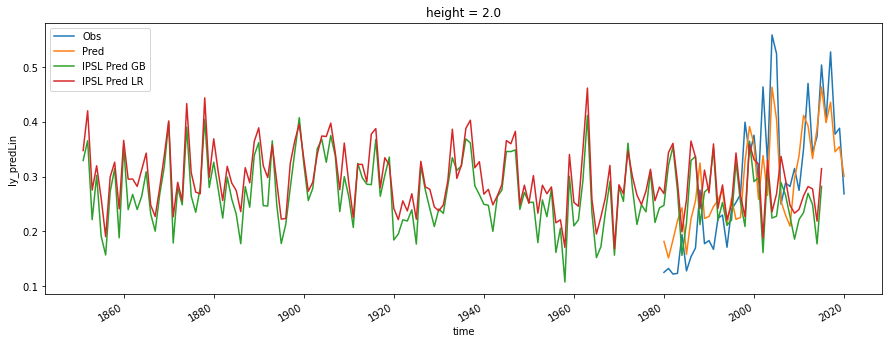

In [29]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')


Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='IPSL Pred GB')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time').plot(label='IPSL Pred LR')

plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)
#y_ds.y.values.corr(y_pred_ds.y_pred.values)

(0.8160695618093241, 0.0)

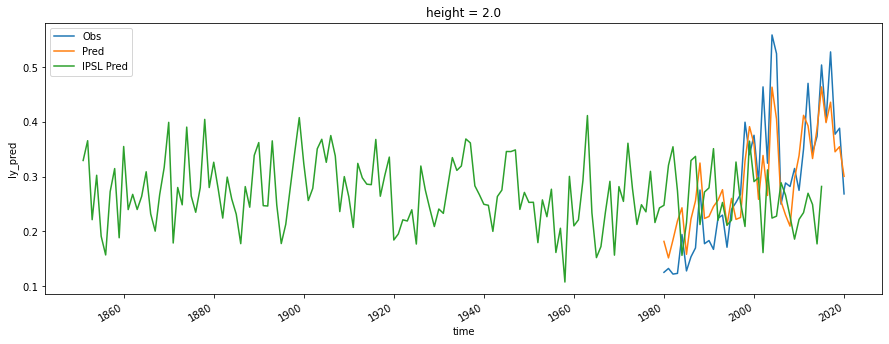

In [28]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='IPSL Pred')


plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)

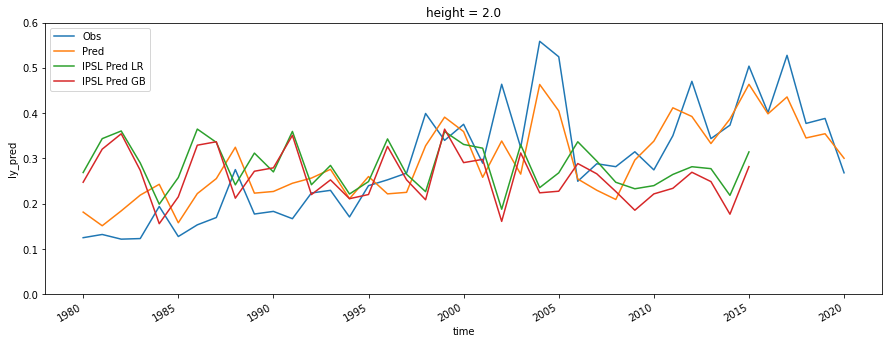

In [48]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[129:].plot(label='IPSL Pred LR')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[129:].plot(label='IPSL Pred GB')
plt.ylim(0, 0.6)
plt.legend()
plt.savefig('../IPSL_yearly.jpeg',dpi=300)

In [56]:
print(np.corrcoef(y_ds.resample(time='1Y').mean().y[:36],Iy_ds.resample(time='1Y').mean().Iy_pred[129:]))
print(np.corrcoef(y_ds.resample(time='1Y').mean().y[:36],IyLin_ds.resample(time='1Y').mean().Iy_predLin[129:]))

[[ 1.         -0.29253415]
 [-0.29253415  1.        ]]
[[ 1.         -0.28362288]
 [-0.28362288  1.        ]]


obsTs=y_ds.resample(time='1M').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%m-%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%m-%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1M').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%m-%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

obsTs=y_ds.resample(time='1Y').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

In [31]:
# Read z500 data
Iz500Data_Orig = I_zLevData.sel(plev=50000)
#Iz500Data


# Calculate anomalies

In [32]:
climatology = Iz500Data_Orig.groupby("time.dayofyear").mean("time")
Iz500Data = Iz500Data_Orig.groupby("time.dayofyear") - climatology
#climatology
Iz500Data.time

<xarray.DataArray 'time' (time: 19840)>
array(['1850-01-01T12:00:00.000000000', '1850-01-02T12:00:00.000000000',
       '1850-01-03T12:00:00.000000000', ..., '2014-12-29T12:00:00.000000000',
       '2014-12-30T12:00:00.000000000', '2014-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
    plev       float32 5e+04
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    standard_name:  time
    long_name:      Time axis
    bounds:         time_bnds
    axis:           T

In [33]:
Iy_ds.Iy_pred
Widespread_Iy1=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
Widespread_Iy=Widespread_Iy1.sel(time=slice('1979-12-1','2014-1-31'))
totalCnt=Widespread_Iy.time.sizes
totalCnt

Frozen({'time': 304})

In [34]:
time1=Widespread_Iy.time
time1

<xarray.DataArray 'time' (time: 304)>
array(['1980-12-03T12:00:00.000000000', '1980-12-04T12:00:00.000000000',
       '1980-12-05T12:00:00.000000000', ..., '2014-01-29T12:00:00.000000000',
       '2014-01-30T12:00:00.000000000', '2014-01-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1980-12-03T12:00:00 ... 2014-01-31T12:00:00
Attributes:
    standard_name:  time
    long_name:      Time axis
    bounds:         time_bnds
    axis:           T

In [35]:
zwide=Iz500Data.sel(time=Widespread_Iy.time,method="nearest")
zwide

<xarray.Dataset>
Dimensions:    (lat: 143, lon: 144, time: 304)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-03T12:00:00 ... 2014-01-31T12:00:00
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
    plev       float32 5e+04
    dayofyear  (time) int64 338 339 340 341 342 343 345 ... 13 14 15 25 29 30 31
    height     float64 2.0
Data variables:
    zg         (time, lat, lon) float32 -7.781 -7.781 -7.781 ... -235.8 -235.8

In [36]:
zwidePos=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes

In [37]:
zwideNeg=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes

In [38]:
zwideAll=zwide.zg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zwideAll

In [39]:
zNeg=zwideNeg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zNeg

zPos=zwidePos.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zPos

In [40]:
zwideNeg

<xarray.DataArray 'zg' (time: 118, lat: 143, lon: 144)>
array([[[  -7.7807617 ,   -7.7807617 ,   -7.7807617 , ...,
           -7.7807617 ,   -7.7807617 ,   -7.7807617 ],
        [ -19.181152  ,  -19.592285  ,  -19.96582   , ...,
          -17.743164  ,  -18.250488  ,  -18.73291   ],
        [ -34.64795   ,  -35.662598  ,  -36.59375   , ...,
          -31.155273  ,  -32.3916    ,  -33.558105  ],
        ...,
        [  45.96875   ,   49.327637  ,   52.612305  , ...,
           35.458008  ,   39.14795   ,   42.38916   ],
        [  24.077637  ,   26.298828  ,   27.950195  , ...,
           18.52539   ,   20.779785  ,   22.570312  ],
        [  14.987793  ,   14.987793  ,   14.987793  , ...,
           14.987793  ,   14.987793  ,   14.987793  ]],

       [[  99.68213   ,   99.68213   ,   99.68213   , ...,
           99.68213   ,   99.68213   ,   99.68213   ],
        [ 103.918945  ,  102.88135   ,  101.83301   , ...,
          107.17383   ,  106.058105  ,  104.992676  ],
        [ 102.80762   ,  100.498535  ,   98.21924   , ...,
          109.82373   ,  107.49805   ,  105.15137   ],
...
        [ -36.87549   ,  -37.061035  ,  -37.17334   , ...,
          -36.11621   ,  -36.391113  ,  -36.645508  ],
        [ -41.993164  ,  -41.927734  ,  -41.836914  , ...,
          -42.132812  ,  -42.087402  ,  -42.046387  ],
        [ -51.859863  ,  -51.859863  ,  -51.859863  , ...,
          -51.859863  ,  -51.859863  ,  -51.859863  ]],

       [[ -96.79639   ,  -96.79639   ,  -96.79639   , ...,
          -96.79639   ,  -96.79639   ,  -96.79639   ],
        [-104.634766  , -105.506836  , -106.34424   , ...,
         -101.73096   , -102.73926   , -103.70801   ],
        [-110.464355  , -112.186035  , -113.81787   , ...,
         -104.75586   , -106.7334    , -108.64502   ],
        ...,
        [  18.638672  ,   19.86621   ,   21.020996  , ...,
           14.789551  ,   16.097168  ,   17.388184  ],
        [  27.60498   ,   28.011719  ,   28.359863  , ...,
           26.502441  ,   26.856445  ,   27.228027  ],
        [  48.770508  ,   48.770508  ,   48.770508  , ...,
           48.770508  ,   48.770508  ,   48.770508  ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-03T12:00:00 ... 2014-01-07T12:00:00
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
    plev       float32 5e+04
    dayofyear  (time) int64 338 340 341 342 343 347 354 ... 25 363 17 18 19 31 7
    height     float64 2.0

In [41]:
zwidePos

<xarray.DataArray 'zg' (time: 186, lat: 143, lon: 144)>
array([[[   5.897461 ,    5.897461 ,    5.897461 , ...,    5.897461 ,
            5.897461 ,    5.897461 ],
        [   6.258789 ,    5.347168 ,    4.45166  , ...,    9.055176 ,
            8.119141 ,    7.1850586],
        [  -0.7426758,   -2.8828125,   -4.9345703, ...,    6.0878906,
            3.7504883,    1.4692383],
        ...,
        [  48.486816 ,   50.348633 ,   52.279785 , ...,   43.103516 ,
           44.81543  ,   46.679688 ],
        [  71.731445 ,   72.740234 ,   73.833496 , ...,   68.85254  ,
           69.73291  ,   70.71533  ],
        [  98.154785 ,   98.154785 ,   98.154785 , ...,   98.154785 ,
           98.154785 ,   98.154785 ]],

       [[  -7.572754 ,   -7.572754 ,   -7.572754 , ...,   -7.572754 ,
           -7.572754 ,   -7.572754 ],
        [ -21.501953 ,  -21.371094 ,  -21.219727 , ...,  -21.734375 ,
          -21.683105 ,  -21.604004 ],
        [ -40.40869  ,  -40.220215 ,  -39.979492 , ...,  -40.703613 ,
          -40.646973 ,  -40.551758 ],
...
        [-239.91846  , -240.91797  , -241.81396  , ..., -236.34814  ,
         -237.6377   , -238.82861  ],
        [-232.4707   , -233.07324  , -233.64258  , ..., -230.51562  ,
         -231.19043  , -231.84668  ],
        [-231.32715  , -231.32715  , -231.32715  , ..., -231.32715  ,
         -231.32715  , -231.32715  ]],

       [[ -74.90137  ,  -74.90137  ,  -74.90137  , ...,  -74.90137  ,
          -74.90137  ,  -74.90137  ],
        [ -67.71338  ,  -67.33057  ,  -66.96094  , ...,  -68.81787  ,
          -68.453125 ,  -68.08447  ],
        [ -62.90039  ,  -61.836914 ,  -60.783203 , ...,  -66.08447  ,
          -65.03613  ,  -63.975098 ],
        ...,
        [-240.77148  , -241.96045  , -242.95898  , ..., -236.19238  ,
         -237.8584   , -239.39014  ],
        [-235.92871  , -236.54004  , -237.07861  , ..., -233.73096  ,
         -234.50732  , -235.24951  ],
        [-235.82861  , -235.82861  , -235.82861  , ..., -235.82861  ,
         -235.82861  , -235.82861  ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-04T12:00:00 ... 2014-01-31T12:00:00
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
    plev       float32 5e+04
    dayofyear  (time) int64 339 345 346 3 4 5 6 23 ... 31 13 14 15 25 29 30 31
    height     float64 2.0

In [42]:
def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([20,40 , 60,80, 100,120, 140], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 10, 20, 30, 40, 50, 60,70], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [43]:
# for contour labels
delta = 5.0
x = np.arange(-60, 60, delta)
y = np.arange(-60, 60, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'


class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


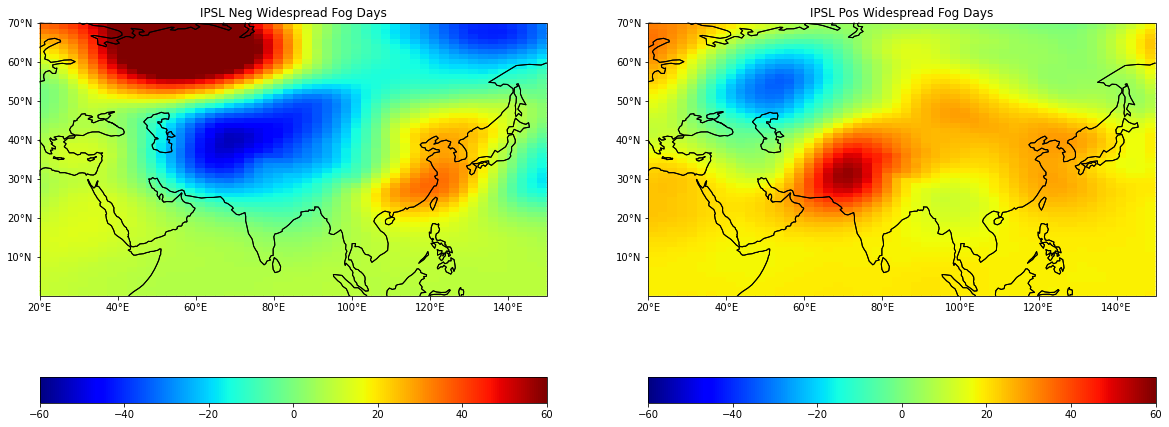

In [44]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
ax1.set_title('IPSL Neg Widespread Fog Days')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.pcolor(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax2)
ax2.coastlines()
ax2.set_title('IPSL Pos Widespread Fog Days')

fig.colorbar(m2,orientation='horizontal')

plt.savefig('../IPSLWDF_pos_Neg.jpeg',dpi=300)


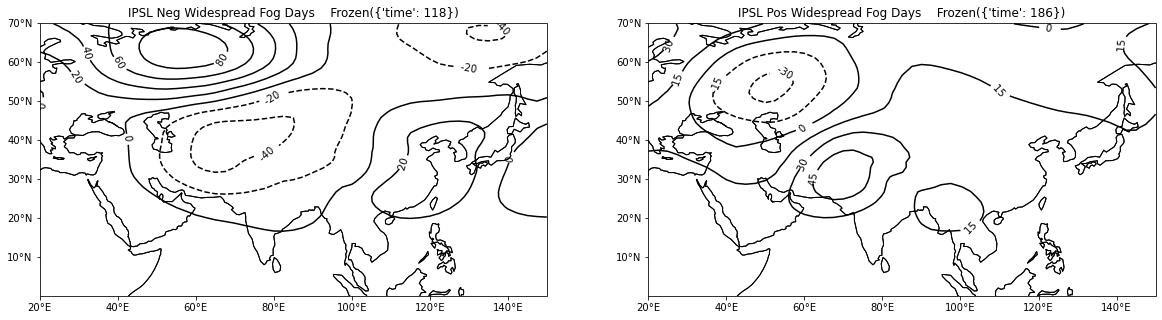

In [45]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title('IPSL Neg Widespread Fog Days'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')


########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.contour(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
map_plot(ax2)
ax2.coastlines()

# Recast levels to new class
m2.levels = [nf(val) for val in m2.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax2.clabel(m2, m2.levels, inline=True, fmt=fmt, fontsize=10)

ax2.set_title('IPSL Pos Widespread Fog Days'+"    "+str(PosCnt))

#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../IPSLWDF_pos_Neg.jpeg',dpi=300)


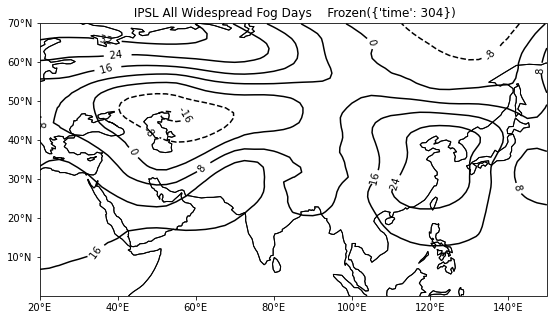

In [46]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zwideAll.lon.values,zwideAll.lat.values,zwideAll,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title(' IPSL All Widespread Fog Days'+"    "+str(totalCnt) )
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../IPSLWDF_All.jpeg',dpi=300)